# Image Cleaning

In [1]:
import numpy as np
import numpy.matlib
import tensorflow as tf
import scipy.io as sio
import time

import utils as utils
import image_generation as imgen
from imshow3D import imshow3D

import matplotlib.pyplot as plt
%matplotlib inline  

#### Test new code

In [2]:
sigma = np.array([1, 1, 1])
sizeI = np.array([64, 64, 64])
pts = utils.random_seed_locations(1000, sizeI)

I = utils.seedBeadsN(pts, sizeI, sigma)
imshow3D(I)

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [3]:
slices = [x for x in range(0,64,8)]
len(slices)

8

In [4]:
start = time.time()
psf = sio.loadmat('../data/psf.mat')
psf = psf['psf']

slices = [x for x in range(14, 114, 5)]
sizei = np.array([64,64,128])
sigmapts = {200:1.5*np.array([1,1,1]), 100:1.75*np.array([1,1,1]), 50:2*np.array([1,1,1])}
im_range = {'lower':0.2, 'upper':0.2, 'gap':0.6}
gauss_noise = {'mean':0, 'std':0.02}
I_noise, I = imgen.create_im_2D(20, sizei, slices, sigmapts, psf,snr=12, 
                                im_range=im_range, gauss_noise=gauss_noise)

end = time.time()
print(end - start)
imshow3D(np.squeeze(np.append(I, I_noise, axis=2)), 0, (12,12))



0.3618044853210449


interactive(children=(RadioButtons(description='Slice plane selection:', index=1, options=('x-y', 'y-z', 'z-x'…

In [13]:
slices = [x for x in range(14, 114, 5)]
len(slices)

20

In [28]:
psf = sio.loadmat('../data/psf.mat')
psf = psf['psf'][:,:,5]
psf.shape

(5, 5)

Old

In [ ]:
sigma = np.array([1, 1])
sizeI = np.array([64, 64])
pts = utils.random_seed_locations(100, sizeI)

I = utils.seedBeadsN(pts, sizeI, sigma)

plt.figure(figsize=(6,6))
plt.imshow(I, cmap='magma')


In [ ]:
I_noise = utils.add_poisson_noise(I, 3)
I_noise = utils.add_gaussian_noise(I_noise, 0, 0.15)

plt.figure(figsize=(6,6))
plt.imshow(I_noise, vmax=1, cmap='magma')


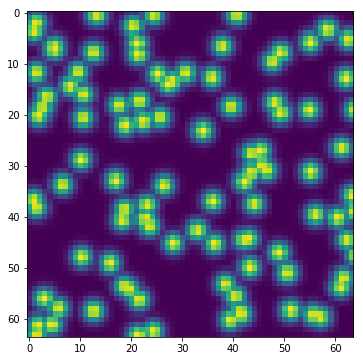

In [5]:
# Generate image dataset
n_images_train = 1000
n_images_test = 1000
sizeI = np.array([64,64])
nPts = 100
sigma = np.array([1,1])
snr = 3
gauss_noise = {'mean':0, 'std':0.15}
im_range = {'lower':0.2, 'upper':0.8}

train_X, train_y = utils.create_im(n_images_train, sizeI, nPts, sigma, snr, gauss_noise, im_range)
test_X, test_y = utils.create_im(n_images_test, sizeI, nPts, sigma, snr, gauss_noise, im_range)

plt.figure(figsize=(6,6))
plt.imshow(np.squeeze(test_y[0,:,:,:]), vmax=1)

## Model

In [6]:
### Hyperparameter
learning_rate = 0.001
batch_size = 20
epochs = 25
display_step = 500

In [7]:
### Input and target placeholders
inputs_ = tf.placeholder(tf.float32, (None,64,64,1), name="input")
targets_ = tf.placeholder(tf.float32, (None,64,64,1), name="input")

### Define Encoder
def encoder(x):
    
    # Layer 1: Conv to 32x32x15
    conv1 = tf.layers.conv2d(inputs=x, 
                             filters=15, 
                             kernel_size=(5,5),
                             strides=(2,2),
                             padding='same',
                             activation=tf.nn.relu)
        
    # Layer 2: Conv to 16x16x30
    conv2 = tf.layers.conv2d(inputs=conv1, 
                             filters=30, 
                             kernel_size=(5,5),
                             strides=(2,2),
                             padding='same',
                             activation=tf.nn.relu)
    
    # Layer 3: Conv to 8x8x45
    conv3 = tf.layers.conv2d(inputs=conv2, 
                             filters=45, 
                             kernel_size=(5,5),
                             strides=(2,2),
                             padding='same',
                             activation=tf.nn.relu)
    return conv3

### Define Decoder
def decoder(x):
    
    # Layer 4: Conv_transpose to 16x16x45
    conv_t4 = tf.layers.conv2d_transpose(inputs=x, 
                                         filters=45, 
                                         kernel_size=(3,3),
                                         strides=(2,2),
                                         padding='same',
                                         activation=tf.nn.relu)
    
    # Layer 5: Conv_transpose to 32x32x30
    conv_t5 = tf.layers.conv2d_transpose(inputs=conv_t4, 
                                         filters=30, 
                                         kernel_size=(5,5),
                                         strides=(2,2),
                                         padding='same',
                                         activation=tf.nn.relu)
    
    # Layer 6: Conv_transpose to 64x64x15
    conv_t6 = tf.layers.conv2d_transpose(inputs=conv_t5, 
                                         filters=15, 
                                         kernel_size=(5,5),
                                         strides=(2,2),
                                         padding='same',
                                         activation=tf.nn.relu)

    # Layer 6: Conv_transpose to 128x128x10
    conv_t7 = tf.layers.conv2d_transpose(inputs=conv_t6, 
                                         filters=10, 
                                         kernel_size=(5,5),
                                         strides=(1,1),
                                         padding='same',
                                         activation=tf.nn.relu)
    
    # Layer 7: Conv to 64x64x1
    conv7 = tf.layers.conv2d(inputs=conv_t7, 
                             filters=1, 
                             kernel_size=(3,3),
                             strides =(1,1),
                             padding='same', 
                             activation=None)
    
    # Make logits 
    logits = tf.slice(conv7, [0, 0, 0, 0], [-1, 64, 64, 1]) 
    
    return logits

### Construct model
encoded = encoder(inputs_)
logits = decoder(encoded)

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [8]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())

for e in range(epochs):
    for i in range(train_X.shape[0]//batch_size - 1):
        imgs_X = train_X[i*batch_size:(i+1)*batch_size,:,:,:]
        imgs_y = train_y[i*batch_size:(i+1)*batch_size,:,:,:]
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs_X,
                                                         targets_: imgs_y})
         # Display logs per step
        if i % display_step == 0:
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}/{}...".format(i+1, train_X.shape[0]//batch_size),
                  "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/25... Step: 1/50... Training loss: 0.6926
Epoch: 2/25... Step: 1/50... Training loss: 0.5270
Epoch: 3/25... Step: 1/50... Training loss: 0.4236
Epoch: 4/25... Step: 1/50... Training loss: 0.3741
Epoch: 5/25... Step: 1/50... Training loss: 0.3576
Epoch: 6/25... Step: 1/50... Training loss: 0.3503
Epoch: 7/25... Step: 1/50... Training loss: 0.3454
Epoch: 8/25... Step: 1/50... Training loss: 0.3427
Epoch: 9/25... Step: 1/50... Training loss: 0.3406
Epoch: 10/25... Step: 1/50... Training loss: 0.3384
Epoch: 11/25... Step: 1/50... Training loss: 0.3368
Epoch: 12/25... Step: 1/50... Training loss: 0.3357
Epoch: 13/25... Step: 1/50... Training loss: 0.3345
Epoch: 14/25... Step: 1/50... Training loss: 0.3335
Epoch: 15/25... Step: 1/50... Training loss: 0.3327
Epoch: 16/25... Step: 1/50... Training loss: 0.3319
Epoch: 17/25... Step: 1/50... Training loss: 0.3313
Epoch: 18/25... Step: 1/50... Training loss: 0.3306
Epoch: 19/25... Step: 1/50... Training loss: 0.3301
Epoch: 20/25... Step:

In [ ]:
n = 10

canvas = np.empty((64 * n, 64*3))
# canvas_recon = np.empty((28 * m, 28 * n))

# Encode and decode the digit image


for i in range(n):
    imgs_X = test_X[i*n:(i+1)*n,:,:,:]
    imgs_y = test_y[i*n:(i+1)*n,:,:,:]
    output = sess.run(decoded, feed_dict={inputs_: imgs_X})
    # Draw the generated digits
    canvas[i*64 : (i+1)*64, 0:64] = np.squeeze(imgs_X[i,:,:,:])
    canvas[i*64 : (i+1)*64, 64:128] = output[i].reshape([64, 64])
    canvas[i*64 : (i+1)*64, 128:192] = np.squeeze(imgs_y[i,:,:,:])

print("Original Images")     
plt.figure(figsize=(18,6*n))
plt.imshow(canvas, vmax=1)
plt.axis('off')
plt.show()

In [ ]:
n = 10

canvas = np.empty((64 * n, 64*3))
# canvas_recon = np.empty((28 * m, 28 * n))

# Encode and decode the digit image
imgs_X = train_X[i*n:(i+1)*n,:,:,:]
imgs_y = train_y[i*n:(i+1)*n,:,:,:]
output = sess.run(decoded, feed_dict={inputs_: imgs_X})

for i in range(n):
    # Draw the generated digits
    canvas[i*64 : (i+1)*64, 0:64] = np.squeeze(imgs_X[i,:,:,:])
    canvas[i*64 : (i+1)*64, 64:128] = output[i].reshape([64, 64])
    canvas[i*64 : (i+1)*64, 128:192] = np.squeeze(imgs_y[i,:,:,:])

print("Original Images")     
plt.figure(figsize=(18,6*n))
plt.imshow(canvas, vmax=1)
plt.axis('off')
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.squeeze(test_y[0,:,:,:]), vmax=1)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(output[2].reshape([64, 64]), vmax=1)
